# 절차

1. 무속 관련 유튜브 채널 후보 리스트 자동 수집
2. 구독자 수, 업로드 수 기준으로 필터
3. 최근 1년 내 영상목록 확보
4. 표본 300편 무작위 추춝
5. 데이터 저장(.xlsx)

In [30]:
from googleapiclient.discovery import build
from tqdm import tqdm
import pandas as pd
import numpy as np

In [16]:
# API Key 세팅
with open('apikey.txt') as f:
    API_KEY = f.read().strip()
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [17]:
def search_channels_by_keyword(keyword, max_results=40):
    results = []
    req = youtube.search().list(
        q=keyword,
        type='channel',
        part='snippet',
        maxResults=max_results
    )
    res = req.execute()
    for item in res['items']:
        results.append({
            'channel_id': item['snippet']['channelId'],
            'channel_title': item['snippet']['title'],
            'keyword': keyword
        })
    return results


In [21]:
# 2. 검색 키워드 리스트
SEARCH_KEYWORDS = ['무당', '무속', '신굿', '굿당', '용한점집', '신점']

In [34]:
all_channels = []
for kw in SEARCH_KEYWORDS:
    all_channels.extend(search_channels_by_keyword(kw, max_results=50))

In [35]:
all_channels

[{'channel_id': 'UCajLD-PJlWxl79EaU4CsEyA',
  'channel_title': '찐무당 여무강신정',
  'keyword': '무당'},
 {'channel_id': 'UCxd6YDhvRmBtIPfNjYi0yuw',
  'channel_title': '무당의모든것',
  'keyword': '무당'},
 {'channel_id': 'UCX_B5kCJjGWjHZwEi_ocWWQ',
  'channel_title': '박사무당 천명도사',
  'keyword': '무당'},
 {'channel_id': 'UCrMBLGzYhQBnB5eq00VMV0g',
  'channel_title': '무당판독기',
  'keyword': '무당'},
 {'channel_id': 'UCOd0Gj9G6KpHKdN_xl2eRvA',
  'channel_title': '무당고춘자',
  'keyword': '무당'},
 {'channel_id': 'UCRAAOkMnOxEPfy7wA98iVBg',
  'channel_title': '더픽 _ [THEPICK] 차트무당',
  'keyword': '무당'},
 {'channel_id': 'UC7oHImEHcHwUKeza4i9xL6Q',
  'channel_title': '당진점집 무당김영월',
  'keyword': '무당'},
 {'channel_id': 'UCSryiBmC5Oue0htOFT_h3mQ',
  'channel_title': '조선무당 TV',
  'keyword': '무당'},
 {'channel_id': 'UCGEaQpgUtfIINT0KSzSMTCQ',
  'channel_title': '박수무당개똥이',
  'keyword': '무당'},
 {'channel_id': 'UCT4X9AvPTOZthtwikVG3l3g',
  'channel_title': '하울신당 천무',
  'keyword': '무당'},
 {'channel_id': 'UCTGrAyH1Lcm9wk2j58Kesgw',
  

In [36]:
len(all_channels)

300

In [37]:
# DataFrame으로 정리
df_channels = pd.DataFrame(all_channels).drop_duplicates('channel_id')
df_channels.head()

,channel_id,channel_title,keyword
0,UCajLD-PJlWxl79EaU4CsEyA,찐무당 여무강신정,무당
1,UCxd6YDhvRmBtIPfNjYi0yuw,무당의모든것,무당
2,UCX_B5kCJjGWjHZwEi_ocWWQ,박사무당 천명도사,무당
3,UCrMBLGzYhQBnB5eq00VMV0g,무당판독기,무당
4,UCOd0Gj9G6KpHKdN_xl2eRvA,무당고춘자,무당


In [38]:
def get_channel_stats(channel_ids):
    stats = []
    for ch_id in tqdm(channel_ids):
        req = youtube.channels().list(
            id=ch_id,
            part='snippet,statistics'
        )
        res = req.execute()
        for item in res['items']:
            stats.append({
                'channel_id': ch_id,
                'channel_title': item['snippet']['title'],
                'subs': int(item['statistics'].get('subscriberCount', 0)),
                'video_count': int(item['statistics'].get('videoCount', 0)),
                'published_at': item['snippet']['publishedAt']
            })
    return pd.DataFrame(stats)

In [39]:

channel_ids = df_channels['channel_id'].tolist()
df_meta = get_channel_stats(channel_ids)
# 필터: 구독자 1만↑, 영상 20편↑
df_meta = df_meta[(df_meta['subs'] >= 10000) & (df_meta['video_count'] >= 20)]
df_meta.head()

100%|█████████████████████████████████████████| 289/289 [00:28<00:00,  9.99it/s]


,channel_id,channel_title,subs,video_count,published_at
0,UCajLD-PJlWxl79EaU4CsEyA,찐무당 여무강신정,10700,325,2018-09-25T00:19:31Z
3,UCrMBLGzYhQBnB5eq00VMV0g,무당판독기,143000,608,2023-10-18T07:59:02.564648Z
4,UCOd0Gj9G6KpHKdN_xl2eRvA,무당고춘자,109000,943,2015-06-30T12:29:15Z
5,UCRAAOkMnOxEPfy7wA98iVBg,더픽 _ [THEPICK] 차트무당,20700,950,2022-11-10T11:01:58.490635Z
6,UC7oHImEHcHwUKeza4i9xL6Q,당진점집 무당김영월,20000,58,2024-02-19T08:18:09.976353Z


In [53]:
df_meta.shape

(56, 5)

In [54]:
df_meta[['channel_title', 'subs', 'video_count']].sort_values('subs', ascending=False)

,channel_title,subs,video_count
172,열린공감TV,1070000,2126
164,윤시원,846000,3435
31,베짱이엔터테인먼트,497000,3239
201,점집 용군TV,464000,19468
38,쌍문동애기선녀TV,327000,1029
249,사주한바퀴,282000,1013
23,일산꽃대신당이화정만신,228000,1169
48,산신무당TV,205000,1127
36,유민지 호신마마,188000,224
40,한울엑소시스트,172000,393


In [55]:
import datetime

def get_video_list_by_channel(channel_id, published_after, max_results=80):
    # published_after: "2023-05-01T00:00:00Z" 형태
    videos = []
    req = youtube.search().list(
        channelId=channel_id,
        part='snippet',
        type='video',
        order='date',
        publishedAfter=published_after,
        maxResults=50
    )
    res = req.execute()
    for item in res['items']:
        videos.append({
            'channel_id': channel_id,
            'video_id': item['id']['videoId'],
            'title': item['snippet']['title'],
            'published_at': item['snippet']['publishedAt']
        })
    return videos



In [56]:
# 최근 1년 기준 ISO 포맷
today = datetime.datetime.now()
one_year_ago = today - datetime.timedelta(days=365)
published_after = one_year_ago.strftime('%Y-%m-%dT%H:%M:%SZ')

all_videos = []
for ch_id in tqdm(df_meta['channel_id'].tolist()):
    videos = get_video_list_by_channel(ch_id, published_after)
    all_videos.extend(videos)

df_videos = pd.DataFrame(all_videos)
df_videos['published_at'] = pd.to_datetime(df_videos['published_at'])
df_videos = df_videos.drop_duplicates('video_id')
df_videos.head()

100%|███████████████████████████████████████████| 56/56 [00:19<00:00,  2.92it/s]


,channel_id,video_id,title,published_at
0,UCajLD-PJlWxl79EaU4CsEyA,FYsxUjRcRfU,찐무당 여무강신정 라이브 방송,2025-05-16 08:34:46+00:00
1,UCajLD-PJlWxl79EaU4CsEyA,4ljIg3EiyWU,인왕산 🪨치마바위🪨 기도터에 다녀왔습니다💕 #인왕산 #치마바위 #장희빈기도터,2025-05-02 03:00:14+00:00
2,UCajLD-PJlWxl79EaU4CsEyA,BzRRUPjaWew,2025년 다가올 큰 재앙은?! #여무강신정 #국운 #대한민국,2025-04-28 10:20:00+00:00
3,UCajLD-PJlWxl79EaU4CsEyA,54OmN-_Ml3k,웃으면 복이 오니까요~☺️ 여러분 모두 재수 많이 받으세,2025-04-24 07:52:25+00:00
4,UCajLD-PJlWxl79EaU4CsEyA,KcLpijec1b8,역대급 이벤트 도착🎁 구독 하신 분들 꼭 보세요!! #여무강신정,2025-04-21 03:13:29+00:00


In [57]:
df_videos.shape

(2407, 4)

In [60]:
df_videos['published_at'].sort_values()

1009   2024-05-22 05:03:58+00:00
1008   2024-05-22 06:00:47+00:00
1709   2024-05-22 11:00:53+00:00
736    2024-05-22 13:11:35+00:00
532    2024-05-23 11:15:03+00:00
                  ...           
419    2025-05-21 11:15:02+00:00
1850   2025-05-21 11:22:52+00:00
1050   2025-05-21 12:44:46+00:00
1283   2025-05-21 12:58:33+00:00
1433   2025-05-21 13:00:06+00:00
Name: published_at, Length: 2407, dtype: datetime64[ns, UTC]

In [62]:
# 무작위 표본 추출
import numpy as np

np.random.seed(42)

sampled_videos = []
for ch_id, group in df_videos.groupby('channel_id'):
    n = min(max(3, int(300 / len(df_meta))), 15)
    sampled = group.sample(n=min(n, len(group)), random_state=42)
    sampled_videos.append(sampled)

df_sample = pd.concat(sampled_videos, ignore_index=True)
# 중복/총합 300±5 조정
if len(df_sample) > 300:
    df_sample = df_sample.sample(n=300, random_state=42)
df_sample.head()

,channel_id,video_id,title,published_at
0,UC-yjT5qhjSWBfeupwjr3UrA,HMBqx_5Hbhs,2025년 중반기 운세 [79년생 양띠 기미생],2025-04-08 05:00:11+00:00
1,UC-yjT5qhjSWBfeupwjr3UrA,PxQYpoFgNIQ,2025년 중반기 운세 [77년생 뱀띠 정사생],2025-03-24 11:04:32+00:00
2,UC-yjT5qhjSWBfeupwjr3UrA,BD0VoR3Qt0A,"[국운예언] 내가 본 미래- 3단계의 대재앙 &quot;물, 하늘, 땅의 재앙&quot;",2025-05-06 02:11:26+00:00
3,UC-yjT5qhjSWBfeupwjr3UrA,KqmDSniB1R0,2025년 중반기 운세 [71년생 돼지띠 신해생],2025-03-24 10:59:01+00:00
4,UC-yjT5qhjSWBfeupwjr3UrA,rRMJLNpMZTw,2025년 중반기 운세 [68년생 원숭띠 무신생],2025-03-28 11:36:42+00:00


In [63]:
df_sample

,channel_id,video_id,title,published_at
0,UC-yjT5qhjSWBfeupwjr3UrA,HMBqx_5Hbhs,2025년 중반기 운세 [79년생 양띠 기미생],2025-04-08 05:00:11+00:00
1,UC-yjT5qhjSWBfeupwjr3UrA,PxQYpoFgNIQ,2025년 중반기 운세 [77년생 뱀띠 정사생],2025-03-24 11:04:32+00:00
2,UC-yjT5qhjSWBfeupwjr3UrA,BD0VoR3Qt0A,"[국운예언] 내가 본 미래- 3단계의 대재앙 &quot;물, 하늘, 땅의 재앙&quot;",2025-05-06 02:11:26+00:00
3,UC-yjT5qhjSWBfeupwjr3UrA,KqmDSniB1R0,2025년 중반기 운세 [71년생 돼지띠 신해생],2025-03-24 10:59:01+00:00
4,UC-yjT5qhjSWBfeupwjr3UrA,rRMJLNpMZTw,2025년 중반기 운세 [68년생 원숭띠 무신생],2025-03-28 11:36:42+00:00
...,...,...,...,...
262,UCyjyfEkAg3gNJ-rKVN-P_KA,j_9eyVhjPS0,저승사자가 부르는 신호일까... 잘 때 손이 자꾸만 올라가면 안된다고? [유민지의 ...,2025-03-10 12:44:20+00:00
263,UCyjyfEkAg3gNJ-rKVN-P_KA,LA_eHFseVto,가위눌림 덕분에 목숨구한 실제사건! 그때 발밑에 나타났던 건 도대체 누구였을까? [...,2024-11-24 12:00:19+00:00
264,UCyjyfEkAg3gNJ-rKVN-P_KA,sShYCGkm0H4,무당이 들려주는 4시간 공포 실화 괴담 모음집! 레전드 사연들만 모았다고?! [유...,2025-01-12 11:33:25+00:00
265,UCyjyfEkAg3gNJ-rKVN-P_KA,cE1ZY2aUpRc,갓신내림 받은 제자 화진선녀가 빙의됐었던 진짜 무서운 얘기.. 실화 공포 괴담 [유...,2024-11-07 12:00:59+00:00


In [64]:
import matplotlib.pyplot as plt
from scipy.stats import chisquare


In [65]:
# 1. 채널별 분포
vid_counts = df_videos['channel_id'].value_counts().sort_index()
samp_counts = df_sample['channel_id'].value_counts().sort_index()


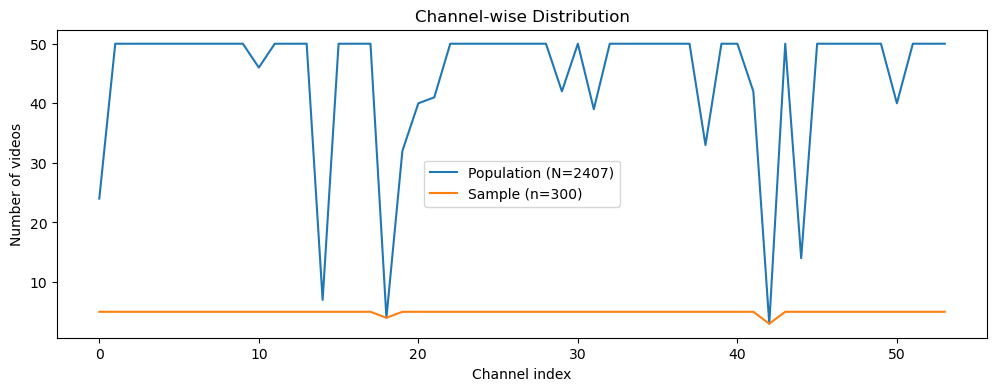

/var/folders/40/n3t1cznx7fndvzjmydb6y6n00000gn/T/ipykernel_45042/3330332115.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_videos['month'] = df_videos['published_at'].dt.to_period('M')
/var/folders/40/n3t1cznx7fndvzjmydb6y6n00000gn/T/ipykernel_45042/3330332115.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_sample['month'] = df_sample['published_at'].dt.to_period('M')


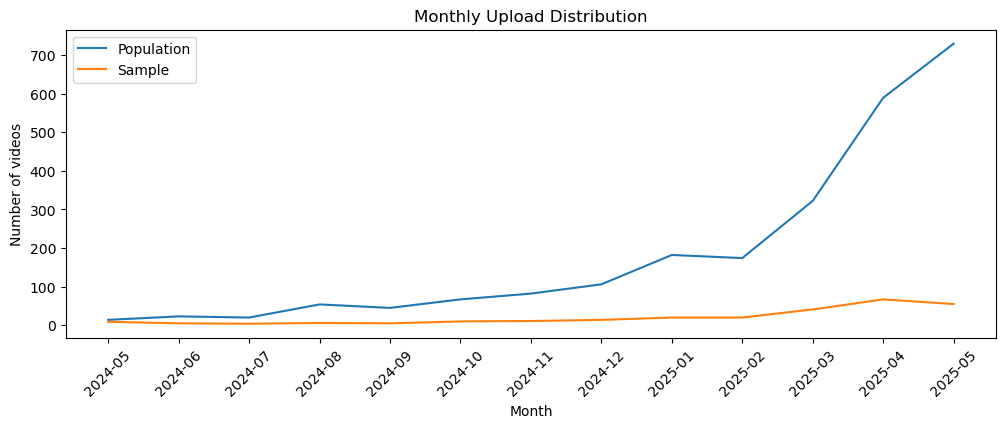

In [66]:
plt.figure(figsize=(12,4))
plt.plot(vid_counts.values, label='Population (N=2407)')
plt.plot(samp_counts.values, label='Sample (n=300)')
plt.title('Channel-wise Distribution')
plt.legend(); plt.xlabel('Channel index'); plt.ylabel('Number of videos')
plt.show()

# 2. 업로드월 분포
df_videos['month'] = df_videos['published_at'].dt.to_period('M')
df_sample['month'] = df_sample['published_at'].dt.to_period('M')

vid_month = df_videos['month'].value_counts().sort_index()
samp_month = df_sample['month'].value_counts().sort_index()

plt.figure(figsize=(12,4))
plt.plot(vid_month.index.astype(str), vid_month.values, label='Population')
plt.plot(samp_month.index.astype(str), samp_month.values, label='Sample')
plt.title('Monthly Upload Distribution')
plt.xticks(rotation=45)
plt.legend(); plt.xlabel('Month'); plt.ylabel('Number of videos')
plt.show()

In [76]:
from scipy.stats import chisquare

# 1. 채널 목록 통일 (모집단, 표본의 union)
all_channels = sorted(set(vid_counts.index) | set(samp_counts.index))

# 2. 관측값: 표본 채널별 영상수 (없으면 0)
obs = samp_counts.reindex(all_channels, fill_value=0)

# 3. 모집단 비율 (없으면 0)
pop_counts = vid_counts.reindex(all_channels, fill_value=0)
exp_prop = pop_counts / pop_counts.sum()

# 4. 기대값: 모집단 비율 × 표본 전체 영상수
f_exp = exp_prop * obs.sum()

# 5. 합계 반드시 일치 (sum(obs)==sum(f_exp))
print("합계:", sum(obs), sum(f_exp))

# 6. chisquare 검정
chi2, p = chisquare(f_obs=obs, f_exp=f_exp)
print(f'Chi-square = {chi2:.2f}, p = {p:.3f}')
# p > 0.05면 '유의한 차이 없음' → 대표성 양호

합계: 267 267.00000000000017
Chi-square = 86.14, p = 0.003
